In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv', header=None)
df = df.dropna()
df.columns = ['lyrics', 'playlist_genre']

In [3]:
df

,lyrics,playlist_genre
0,"The trees, are singing in the wind The sky blu...",rock
1,"NA Yeah, Spyderman and Freeze in full effect U...",r&b
2,I really can't stay Baby it's cold outside I'v...,r&b
3,"Hold your breath, don't look down, keep trying...",r&b
4,All I want is somebody who's gonna love me for...,r&b
...,...,...
15096,"Yeah, nah, nah, nah, nah, nah, nah, nah, nah N...",r&b
15097,"Caught up in such a head rush, wide-eyed latel...",edm
15098,"My anaconda don't, my anaconda don't My anacon...",pop
15099,"Bound, bound Bound, bound Bound to fall in lov...",r&b


In [4]:
from keras_bert import extract_embeddings
from keras_bert import load_vocabulary
from keras_bert import Tokenizer

model_path = './uncased_L-8_H-512_A-8'
dict_path = model_path+'/vocab.txt'

bert_token_dict = load_vocabulary(dict_path)
bert_tokenizer = Tokenizer(bert_token_dict)

for x in df['lyrics'].values.tolist():
    tokens = bert_tokenizer.tokenize(x)
    indices, segments = bert_tokenizer.encode(first=x)

embeddings = extract_embeddings(model_path, df['lyrics'].values.tolist())


KeyboardInterrupt: 

In [57]:
# print(len(embeddings))
# X_convert = []

# for x in range(len(embeddings)):
#     X_convert.append(embeddings[x][0])

# # save X_convert into csv
# import csv
# with open('X_convert.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerows(X_convert)

15101


In [5]:
df = pd.read_csv('datawithfold.csv', usecols=lambda column: column != 'Unnamed: 0')

# Separate the features (x) and the target variable (y)
x = df.drop(['y', 'fold'], axis=1)
y = df['y']

# Split the data into train and test sets based on the fold column
x_train = x[df['fold'] == 1]
y_train = y[df['fold'] == 1]
x_test = x[df['fold'] == 0]
y_test = y[df['fold'] == 0]

13534
1567


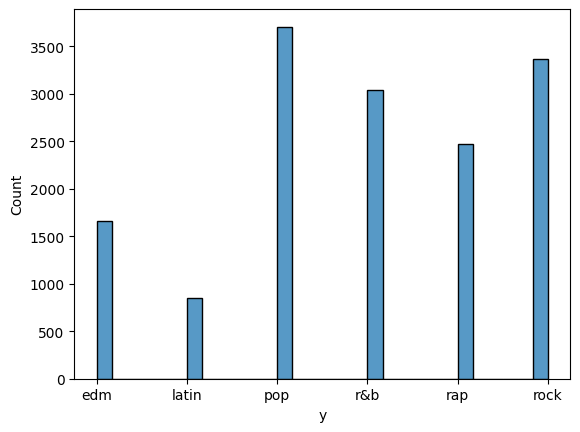

In [8]:
import seaborn as sns

classes = {'edm': 1, 'latin': 2, 'pop': 3, 'r&b': 4, 'rap': 5, 'rock': 6}

print(y_train.value_counts().sum())
print(y_test.value_counts().sum())
# plot the distribution of the target variable
sns.histplot(y_train, kde=False, bins=30)
plt.xticks(list(classes.values()), list(classes.keys()))
plt.savefig('train.png')
plt.show()

# plot the distribution of the target variable
sns.histplot(y_test, kde=False, bins=30)
plt.xticks(list(classes.values()), list(classes.keys()))
plt.savefig('test.png')
plt.show()


sns.histplot(tmp, kde=False, bins=30)
plt.xticks(list(classes.values()), list(classes.keys()))
plt.savefig('test.png')
plt.show()

In [75]:
import optuna
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def objective_svm(trial):
    # create model
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
        model = SVC(kernel=kernel, degree=degree, C=trial.suggest_float('C', 0, 1))
    elif kernel == 'rbf':
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        model = SVC(kernel=kernel, gamma=gamma, C=trial.suggest_float('C', 0, 1))
    else:
        model = SVC(kernel=kernel, C=trial.suggest_float('C', 0, 1))

    # fit model
    model.fit(x_train, y_train)
    # evaluate the model
    y_pred = model.predict(x_test)

    # calculate f1 macro score
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # maximize f1 macro score
    return f1_macro

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=25)

print('Best trial:')
trial = study_svm.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-12-28 15:57:21,895] A new study created in memory with name: no-name-fe891b23-52a9-4577-845a-9bd9f841e8e6
[I 2023-12-28 15:58:12,783] Trial 0 finished with value: 0.45240460967392426 and parameters: {'kernel': 'poly', 'degree': 3, 'C': 0.7403394083303491}. Best is trial 0 with value: 0.45240460967392426.
[I 2023-12-28 15:59:06,765] Trial 1 finished with value: 0.46396066109005574 and parameters: {'kernel': 'linear', 'C': 0.1357746945816114}. Best is trial 1 with value: 0.46396066109005574.
[I 2023-12-28 16:00:29,943] Trial 2 finished with value: 0.472717420149286 and parameters: {'kernel': 'linear', 'C': 0.9414451435091025}. Best is trial 2 with value: 0.472717420149286.
[I 2023-12-28 16:01:44,014] Trial 3 finished with value: 0.18468189716307357 and parameters: {'kernel': 'sigmoid', 'C': 0.012578891938411663}. Best is trial 2 with value: 0.472717420149286.
[I 2023-12-28 16:02:45,875] Trial 4 finished with value: 0.36320723525102827 and parameters: {'kernel': 'poly', 'degree': 

Best trial:
Value:  0.4742840270207325
Params: 
    kernel: linear
    C: 0.987857384235793


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [77]:
# Params: 
#     kernel: linear
#     C: 0.987857384235793

# use the best hyperparameters to build the SVM model
best_params = study_svm.best_params
model_svm = SVC(**best_params)
# fit model
model_svm.fit(x_train, y_train)
# evaluate the model
y_pred = model_svm.predict(x_test)
print('f1 score:', f1_score(y_test, y_pred, average='macro'))


f1 score: 0.4742840270207325


              precision    recall  f1-score   support

           1       0.48      0.38      0.42       173
           2       0.28      0.06      0.09        90
           3       0.41      0.55      0.47       372
           4       0.56      0.51      0.53       327
           5       0.71      0.74      0.72       235
           6       0.60      0.61      0.60       370

    accuracy                           0.54      1567
   macro avg       0.51      0.47      0.47      1567
weighted avg       0.53      0.54      0.53      1567

0.4742840270207325
[[ 65   1  69  14   4  20]
 [  9   5  39  18   9  10]
 [ 27   6 206  49  19  65]
 [ 10   4  78 166  33  36]
 [  7   1  15  23 173  16]
 [ 17   1  95  28   5 224]]


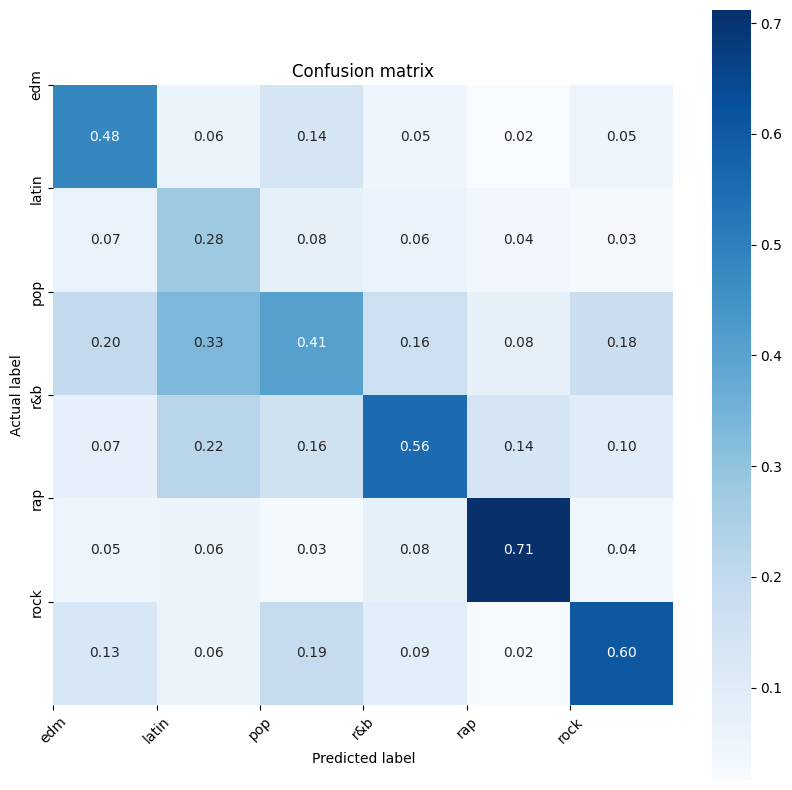

In [107]:
import seaborn as sns
# get the confusion matrix, precision, recall, f1 score
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

classes = {'edm': 1, 'latin': 2, 'pop': 3, 'r&b': 4, 'rap': 5, 'rock': 6}

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# devide each value in the confusion matrix by the sum of the col
cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis,:]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', fmt='.2f')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
# change label into genre
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.savefig('confusion_matrix.png')
plt.show()

